# Machine Translation + Transformer

## Task 0 Import libraries and define device to CUDA

In [1]:
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import random, math, time
import copy
import pickle

from datasets import Dataset, DatasetDict, load_dataset
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1.1
Find a dataset suitable for translation between your native language and English. Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation. (1 points)

**Note**: As a Myanmar Nationality, I choose ENGLISH - MYANMAR text pair as my dataset.

- I obtained my dataset from https://www2.nict.go.jp/astrec-att/member/mutiyama/ALT/

- The copyright holder of the translations of the ALT Parallel Corpus is the National Institute of Information and Communications Technology, Japan (NICT). 

- The University of Computer Studies, Yangon, Myanmar helped NICT translate the English texts into the Myanmar texts.

In [4]:
dataset = load_dataset('alt')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 18088
    })
    validation: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1019
    })
})

In [6]:
dataset['train']

Dataset({
    features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
    num_rows: 18088
})

In [7]:
dataset['train'][12]

{'SNT.URLID': '87564',
 'SNT.URLID.SNTID': '13',
 'url': 'http://en.wikinews.org/wiki/Data_for_3_million_UK_driving_candidates_lost',
 'translation': {'bg': 'অক্টোবরে এইচএম রেভিনিউ ২৫ মিলিয়ন লোকের তথ্য হারিয়ে ফেলার পরে এটিই হল ইউকে-তে প্রথম এত বড় তথ্যের ক্ষতি।',
  'en': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October.',
  'en_tok': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October .',
  'fil': 'Ito ang unang malakihang pagkawala ng data sa UK dahil ang impormasyon sa 25 milyong tao ay nawalan ng HM Revenue noong Oktubre.',
  'hi': 'यह ब्रिटेन में डेटा का पहला बड़ा नुकसान है क्योंकि अक्टूबर में HM रेवेन्यू द्वारा 25 मिलियन लोगों की जानकारी गुम हो गई थी।',
  'id': 'Ini adalah kehilangan data yang besar pertama di UK sejak hilangnya informasi tentang 25 juta orang oleh HM Revenue di bulan Oktober.',
  'ja': 'これは、10月に歳入関税庁が2500万人分の情報を失って以来初めてのイギリスでの大きな

In [8]:
dataset['train'][12]['translation']

{'bg': 'অক্টোবরে এইচএম রেভিনিউ ২৫ মিলিয়ন লোকের তথ্য হারিয়ে ফেলার পরে এটিই হল ইউকে-তে প্রথম এত বড় তথ্যের ক্ষতি।',
 'en': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October.',
 'en_tok': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October .',
 'fil': 'Ito ang unang malakihang pagkawala ng data sa UK dahil ang impormasyon sa 25 milyong tao ay nawalan ng HM Revenue noong Oktubre.',
 'hi': 'यह ब्रिटेन में डेटा का पहला बड़ा नुकसान है क्योंकि अक्टूबर में HM रेवेन्यू द्वारा 25 मिलियन लोगों की जानकारी गुम हो गई थी।',
 'id': 'Ini adalah kehilangan data yang besar pertama di UK sejak hilangnya informasi tentang 25 juta orang oleh HM Revenue di bulan Oktober.',
 'ja': 'これは、10月に歳入関税庁が2500万人分の情報を失って以来初めてのイギリスでの大きなデータ紛失である。',
 'khm': 'នេះជាការបាត់បង់ទិន្នន័យដ៏ធំំលើកទីមួយក្នុងចក្រភពអង់គ្លេសបន្ទាប់ពីបានបាត់បង់ព័ត៌មាន25លាននាក់នៅទីភ្នាក់ងារចំណូលគយនៅខែតុលា។',
 'lo': 'ນີ້ແມ

In [9]:
dataset['train'][12]['translation']['en']

'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October.'

In [10]:
dataset['train'][12]['translation']['my']

'အဆိုပါကိစ္စ သည် အောက်တိုဘာလ တွင် လူ ၂၅ သန်း ၏ သတင်းအချက်အလက်များ အခွန်ဝန်ကြီးဌာန ကြောင့် ဆုံးရှုံးခဲ့ ကတည်းက ဗြိတိန်နိုင်ငံ တွင် ပထမဦးဆုံးသော အဓိကကျသည့် အချက်အလက်များ ၏ ပျောက်ဆုံးမှု ဖြစ်သည် ။'

## Task 1.2
Describe in detail the process of preparing the dataset for use in your translation model. This includes steps like text normalization, tokenization, and word segmentation, particularly focusing on your native language’s specific requirements. Specify the libraries or tools you will use for these tasks and give appropriate credit to the developers or organizations behind these tools. If your native language requires special handling in tokenization (e.g., for languages like Chinese, Thai, or Japanese), mention the libraries (like Jieba, PyThaiNLP, or Mecab) and the procedures used for word segmentation. (1 points)

1.  Initially the dataset contains english and multiple Asian language pairs. I firstly split it into English and Myanmar pair.
2. ENGLISH tokenization done using spacy tokenizer with the en_core_web_sm model.
3. MYANMAR tokenization done using custom tokenizer for Myanmar using the Viterbi algorithm for word segmentation. This is a sophisticated approach and well-suited for Myanmar, which requires word segmentation. (Full credit to Dr. Ye Kyaw Thu for the Viterbi algorithm implementation. [https://github.com/ye-kyaw-thu/myWord] )
4. Vocabulary buidling: Tokenized English and Myanmar text are used to build a vocabulary. The vocabulary is then used to convert text into numerical indices for further processing.

In [11]:
# Create new dataset of English and Myanmar pair

datasetENMY = {}

# Define source and target languages
SRC_LANGUAGE = 'en'  # English
TRG_LANGUAGE = 'my'  # Myanmar
languages   = [SRC_LANGUAGE, TRG_LANGUAGE]

for data in dataset:
# english myanmar data
    datasetENMY[data] = [{lang: row['translation'][lang] for lang in languages} for row in dataset[data]]

In [12]:
# check the size for each dataset
for data in datasetENMY:
    print(f"{data} : {len(datasetENMY[data])}")

train : 18088
validation : 1000
test : 1019


In [13]:
sample = datasetENMY['train'][100]

In [14]:
sample[SRC_LANGUAGE]

'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.'

In [15]:
sample[TRG_LANGUAGE]

'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'

### Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [16]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [17]:
# English language tokenization
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


In [18]:
#example of tokenization of the english part
print("Sentence: ", sample[SRC_LANGUAGE])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE]))

Sentence:  The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.
Tokenization:  ['The', 'TimesOnline', 'reports', 'that', 'the', 'joke', 'fell', 'flat', 'with', 'Jeffrey', 'Turner', ',', 'who', 'as', 'Chief', 'of', 'Police', 'in', 'Clayton', 'County', ',', 'Georgia', ',', 'put', 'Mr', 'Whitton', 'on', 'medical', 'leave', 'when', 'he', 'was', 'shot', 'in', 'the', 'wrist', 'as', 'he', 'tried', 'to', 'foil', 'a', 'robbery', 'earlier', 'this', 'summer', '.']


In [19]:
# Myanmar language custom tokenization
"""

This code is from https://github.com/ye-kyaw-thu/myWord/blob/main/word_segment.py
Full Credit to Dr.Ye Kyaw Thu.

Ye Kyaw Thu (Ye-san) is a Visiting Professor of Language & Semantic Technology Research Team (LST), Artificial Intelligence Research Unit (AINRU), National Electronic & Computer Technology Center (NECTEC), Thailand, Affiliate Professor at Cambodia Academy of Digital Technology (CADT), Cambodia and Head of NLP Research Lab., University of Technology Yatanarpon Cyber City (UTYCC), Pyin Oo Lwin, Myanmar.

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

# unigram and bigram dictionary from https://github.com/ye-kyaw-thu/myWord/tree/main/dict_ver1
uni_dict_bin = '../app/data/unigram-word.bin'
bi_dict_bin = '../app/data/bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
    #def __init__(self, datafile=None, unigram=True, N=1024908267229):
    #def __init__(self, datafile=None, unigram=True, N=8199266137832):
        #data = {}
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10 / (N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1 / N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    #print("text: ", text)
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []
    #print("clear candidates!  candidates = []")
    for first_word, remain_word in splits:
        #pdb.set_trace()
        first_prob = math.log10(conditionalProb(first_word, prev))
        #print("first_prob of condProb(", first_word, ", ", prev, "): ", first_prob )
        remain_prob, remain_word = viterbi(remain_word, first_word)
        #print("remain_prob: ", remain_prob, ", remain_word: ", remain_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        #print("first_prob: ", str(first_prob), ", remain_prob: ", remain_prob, ", [first_word]:", [first_word], ", remain_word: ", remain_word)
        #print("Candidates: ", candidates)
        
    #print("max(candidates): " + str(max(candidates)))
    #print("====================")
    return max(candidates)


In [20]:
def my_tokenizer(text):
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input      = text[:]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    wordStr    = wordDelimiter.join(listString[1])
    wordClean1 = wordStr.strip()
    wordClean2 = wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [21]:
sample

{'en': 'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.',
 'my': 'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'}

In [22]:
token_transform[TRG_LANGUAGE] = my_tokenizer

In [23]:
#example of tokenization of the myanmar part
print("Sentence: ", sample[TRG_LANGUAGE])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE]))

Sentence:  ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။
Tokenization:  ['ယခု', 'နွေရာသီ', 'အစောပိုင်း', 'ကာလ', '၌', 'လုယက်', 'မှု', 'တစ်', 'ခု', 'ကျူးလွန်', 'ရန်', 'ကြိုးစား', 'ခဲ့', 'သော', 'ကြောင့်', 'လက်', 'ကောက်', '၀', 'တ်', 'တွင်', 'သေနတ်ကျည်', 'မှန်', 'ခဲ့', 'သော', 'မ', 'စ်', 'စ', 'တာ', '၀ှစ်', 'တွန်', 'ကို', 'က', 'လေ', 'တွန်', 'ကောင်', 'တီ', '၊', 'ဂျော်ဂျီယာ', 'ပြည်နယ်', 'မှ', '၊', 'ရဲမှူးကြီး', 'ဂျက်', 'ဖရီ', 'တာ', 'နာ', 'မှ', 'ဆေး', 'ခွင့်', 'ပေး', 'တာ', 'နှင့်', 'ပတ်', 'သတ်', 'ပြီး', '၊', 'တိုင်းမ်စ်', 'အွန်လိုင်း', 'မှ', 'ဟာသ', 'ပြက်လုံး', 'တစ်', 'ခု', 'ကို', 'မှတ်တမ်းတင်', 'ရေး', 'သား', 'ခဲ့', 'သည်', '။']


In [24]:
# Clone datasetENMY for use later
corpus = copy.deepcopy(datasetENMY)

A function to tokenize our input.

In [25]:
# helper function to yield list of tokens
# here data can be 'train' or 'val' or 'test' 
def yield_tokens(data, language):
    # language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE:1}
    
    for data_sample in data:
        yield token_transform[language](data_sample[language])
        # either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [26]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [27]:
# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     # Create torchtext's Vocab object 
#     vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
#                                                     min_freq = 2,   # if not, everything will be treated as UNK
#                                                     specials = special_symbols,
#                                                     special_first = True) # indicates whether to insert symbols at the beginning or at the end                                            
# # Set UNK_IDX as the default index. This index is returned when the token is not found. 
# # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     vocab_transform[ln].set_default_index(UNK_IDX)

In [28]:
# Save the vocab with pickle for Use later

# pickle.dump(vocab_transform, open('../app/data/vocab.pkl', 'wb'))

Vocab is saved and loaded for further use and to save time for rerun.

In [29]:
# load the vocab
vocab_transform = pickle.load(open('../app/data/vocab.pkl', 'rb'))

In [30]:
#see some example of english token
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[880, 18, 12, 0, 12]

In [31]:
#see some example of myanmar token
vocab_transform[TRG_LANGUAGE](['သူ', 'နွေရာသီ', 'တစ်', 'ခု'])

[14, 1134, 16, 20]

In [32]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 880, for example
mapping[880]

'here'

In [33]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [34]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [35]:
#check unique vocabularies
len(mapping)

16912

## Task 2 Experiment: Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [36]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids, device):
    return torch.cat((torch.tensor([SOS_IDX], device=device), 
                      torch.tensor(token_ids, device=device), 
                      torch.tensor([EOS_IDX], device=device)))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],  # Tokenization
                                               vocab_transform[ln],  # Numericalization
                                               lambda x: tensor_transform(x, device=device))  # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_batch(batch, device):
    src_batch, src_len_batch, trg_batch = [], [], []
    for row in batch:

        # Check if the required fields are not None
        if row[SRC_LANGUAGE] is None or row[TRG_LANGUAGE] is None:
            print(f"Skipping row with missing data: {row}")  # Optional: print to debug
            continue  # Skip this row if it's missing source or target data
        
        processed_text = text_transform[SRC_LANGUAGE](row[SRC_LANGUAGE].rstrip("\n"))
        trg_text = text_transform[TRG_LANGUAGE](row[TRG_LANGUAGE].rstrip("\n"))
        
        src_batch.append(processed_text)
        trg_batch.append(trg_text)
        src_len_batch.append(processed_text.size(0))

    # Pad sequences and ensure they're on the correct device
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True).to(device) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True).to(device)
    
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64, device=device), trg_batch

Create train, val, and test dataloaders

In [37]:
corpus

{'train': [{'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
   'my': 'ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။'},
  {'en': 'Andrea Masi opened the scoring in the fourth minute with a try for Italy.',
   'my': 'အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု အဖြစ် စတုတ္ထ မိနစ် တွင် အမှတ်ပေးခြင်း ကို ဖွင့်လှစ်ပေးခဲ့သည် ။'},
  {'en': 'Despite controlling the game for much of the first half, Italy could not score any other tries before the interval but David Bortolussi kicked three penalties to extend their lead.',
   'my': 'ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကို ထိန်းချုပ်ခြင်း မရှိခဲ့လျှင် အီတလီ သည် ပွဲနားချိန် မတိုင်မှီ အခြား မည်သည့် ကြိုးစားမှု များ ကိုမှ အမှတ် မရနိုင် ပေမယ့် ဒေးဗစ် ဘော်တိုလပ်စီ သည် သူတို့၏ ဦးဆောင်မှု ကို အဓွန့်ရှည် စေရန် ပယ်နယ်လ်တီ ၃ဂိုး သွင်းပေးခဲ့သည် ။'},
  {'en': 'Portugal ne

In [38]:
train   = corpus['train'][:1000] #First 1000 
val     = corpus['validation'][:100] #First 100 
test    = corpus['test'][:100] #First 100 

In [39]:
# train   = corpus['train'][:10] #First 1000 
# val     = corpus['validation'][:1] #First 100 
# test    = corpus['test'][:1] #First 100 

In [40]:
batch_size = 16

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_batch(batch, device))
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, device))
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, device))

In [41]:
train_loader

Let's test the train loader.

In [42]:
for en, _, my in train_loader:
    break

In [43]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Myanmar shape: ", my.shape)   # (batch_size, seq len)

English shape:  torch.Size([16, 53])
Myanmar shape:  torch.Size([16, 75])


## 5. Design the model

### Encoder Layer

In [44]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [45]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

General Attention Layer

In [46]:
class MultiHeadGeneralAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

Multiplicative Attention Layer

In [47]:
class MultiHeadMultiplicativeAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.W        = nn.Linear(self.head_dim, self.head_dim) # for decoder input_ (note: not the same)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key   = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]
        
        # update the size for matrix multiplication
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]
        
        # calculate the energy/ attention score
        energy = torch.matmul(self.W(Q), K.permute(0,1,3,2)) / self.scale # multiplicative attention
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len]
        
        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        # x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]
        
        return x, attention

Additive Attention Layer

In [48]:
class MultiHeadAdditiveAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        # input >> Q, K, V
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        # for additive v, U, W
        self.vv = nn.Linear(self.head_dim, 1, bias = False)
        self.W = nn.Linear(self.head_dim, self.head_dim) # for decoder input_ (W2)
        self.U = nn.Linear(self.head_dim, self.head_dim)  # for encoder_outputs (W1)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key   = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        query_len  = query.shape[1]
        key_len    = key.shape[1]
        
        # linear transform for the input
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]
        
        # update the size for matrix multiplication
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]
    
        Q = Q.view(batch_size, self.n_heads, query_len, 1, self.head_dim)
        K = K.view(batch_size, self.n_heads, 1, key_len, self.head_dim)
        
        # calculate the energy : for additive
        energy = (self.vv(torch.tanh(self.W(Q) + self.U(K))) / self.scale).squeeze(4)
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len, 1] >> squeeze(4)
        # energy = [batch_size, n heads, query len, key len]
        
        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        # x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]
        
        return x, attention
    

### Position-wise Feedforward Layer

In [49]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [50]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [51]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attention, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [52]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training

In [53]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [54]:
# Set Parameters for my models
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

# Initialize Encoder and Decoder for General attention
enc_general_attention = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device,attention = MultiHeadGeneralAttentionLayer)
dec_general_attention = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, device,attention = MultiHeadGeneralAttentionLayer)

# Initialize Encoder and Decoder for Multiplicative attention
enc_multiplicative_attention = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device,attention = MultiHeadMultiplicativeAttentionLayer)
dec_multiplicative_attention = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, device,attention = MultiHeadMultiplicativeAttentionLayer)

# Initialize Encoder and Decoder for Additive attention
enc_additive_attention = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device,attention = MultiHeadAdditiveAttentionLayer)
dec_additive_attention = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, device,attention = MultiHeadAdditiveAttentionLayer)

# Create General attention model
model_general_attention      = Seq2SeqTransformer(enc_general_attention, dec_general_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_general_attention.apply(initialize_weights)

# Create Multiplicative attention model
model_multiplicative_attention = Seq2SeqTransformer(enc_multiplicative_attention, dec_multiplicative_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative_attention.apply(initialize_weights)

# Create Additive attention model
model_additive_attention     = Seq2SeqTransformer(enc_additive_attention, dec_additive_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_additive_attention.apply(initialize_weights)


Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16912, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAdditiveAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (vv): Linear(in_features=32, out_features=1, bias=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (U): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLay

In [55]:
# Create a Dict to store different models for easy access, iteration in future
all_models = {
    'generalAttention': model_general_attention,
    'multiplicativeAttention': model_multiplicative_attention,
    'additiveAttention' : model_additive_attention
    }

In [56]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
    #     print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
# count_parameters(model)
for i,model in enumerate(all_models):
    count_parameters(all_models[model])


______
12658013
______
12667517
______
12677309


In [57]:
import torch.optim as optim

# Set learning rate
lr = 0.0005

#training hyperparameters for general attention
optimizer_general_attention = optim.Adam(model_general_attention.parameters(), lr=lr)
criterion_general_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX) #combine softmax with cross entropy

#training hyperparameters for multiplicative attention
optimizer_multiplicative_attention = optim.Adam(model_multiplicative_attention.parameters(), lr=lr)
criterion_multiplicative_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX) #combine softmax with cross entropy

#training hyperparameters for additive attention
optimizer_additive_attention = optim.Adam(model_additive_attention.parameters(), lr=lr)
criterion_additive_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [58]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [59]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [60]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [61]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    elapsed_millis = int((elapsed_time - int(elapsed_time)) * 1000)  # get milliseconds
    return elapsed_mins, elapsed_secs, elapsed_millis

In [62]:
# Initialize dictionary to store records of model performance
model_records = {}

# Define a Custom Function to call for training all models
def train_model(model, optimizer, criterion, model_name):
    
    best_train_loss = float('inf')
    best_train_PPL  = float('inf')
    best_valid_loss = float('inf')
    best_valid_PPL  = float('inf')
    
    num_epochs = 5
    clip       = 1

    save_path = f'../models/{model_name}.pt'

    train_losses = []
    valid_losses = []
    
    start = time.time()

    for epoch in range(num_epochs):
        
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs, epoch_millis = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_train_loss = train_loss
            best_train_PPL  = math.exp(train_loss)
            best_valid_loss = valid_loss
            best_valid_PPL = math.exp(valid_loss)
            torch.save(model.state_dict(), save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s {epoch_millis}ms')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        #lower perplexity is better

    end = time.time()
    total_mins, total_secs, total_millis = epoch_time(start, end)

    print(f"Total training time: {total_mins}m {total_secs}s {total_millis}ms")

    # save the records
    model_records[model_name] = {'train_losses' : train_losses,
                               'valid_losses'   : valid_losses,
                               'best_train_loss': best_train_loss,
                               'best_train_PPL' : best_train_PPL,
                               'best_valid_loss': best_valid_loss,
                               'best_valid_PPL' : best_valid_PPL,
                               'total_mins'     : total_mins,
                               'total_secs'     : total_secs}


## Task 2.1: General Attention (0.5 Point)

In [63]:
# Run the custom training function for general attention model
train_model (model_general_attention, optimizer_general_attention, criterion_general_attention, "generalAttention")

Epoch: 01 | Time: 1m 53s 924ms
	Train Loss: 6.818 | Train PPL: 914.172
	 Val. Loss: 6.113 |  Val. PPL: 451.755
Epoch: 02 | Time: 1m 54s 74ms
	Train Loss: 5.672 | Train PPL: 290.729
	 Val. Loss: 5.536 |  Val. PPL: 253.571
Epoch: 03 | Time: 1m 54s 384ms
	Train Loss: 5.000 | Train PPL: 148.465
	 Val. Loss: 5.328 |  Val. PPL: 206.085
Epoch: 04 | Time: 1m 54s 159ms
	Train Loss: 4.556 | Train PPL:  95.246
	 Val. Loss: 5.248 |  Val. PPL: 190.192
Epoch: 05 | Time: 1m 54s 532ms
	Train Loss: 4.200 | Train PPL:  66.714
	 Val. Loss: 5.214 |  Val. PPL: 183.789
Total training time: 9m 31s 497ms


## Task 2.2: Multiplicative Attention  (0.5 Point)

In [64]:
# Run the custom training function for Multiplicative attention model
train_model (model_multiplicative_attention, optimizer_multiplicative_attention, criterion_multiplicative_attention, "multiplicativeAttention")

Epoch: 01 | Time: 1m 55s 313ms
	Train Loss: 6.796 | Train PPL: 894.328
	 Val. Loss: 6.084 |  Val. PPL: 438.685
Epoch: 02 | Time: 2m 2s 635ms
	Train Loss: 5.630 | Train PPL: 278.694
	 Val. Loss: 5.521 |  Val. PPL: 249.871
Epoch: 03 | Time: 2m 36s 192ms
	Train Loss: 4.989 | Train PPL: 146.740
	 Val. Loss: 5.307 |  Val. PPL: 201.767
Epoch: 04 | Time: 1m 56s 624ms
	Train Loss: 4.557 | Train PPL:  95.324
	 Val. Loss: 5.226 |  Val. PPL: 185.971
Epoch: 05 | Time: 1m 56s 388ms
	Train Loss: 4.206 | Train PPL:  67.083
	 Val. Loss: 5.194 |  Val. PPL: 180.127
Total training time: 10m 27s 577ms


## Task 2.3: Additive Attention  (0.5 Point)

In [65]:
# Run the custom training function for Additive attention model
train_model (model_additive_attention, optimizer_additive_attention, criterion_additive_attention, "additiveAttention")

Epoch: 01 | Time: 2m 3s 441ms
	Train Loss: 6.795 | Train PPL: 893.205
	 Val. Loss: 6.031 |  Val. PPL: 416.258
Epoch: 02 | Time: 2m 1s 551ms
	Train Loss: 5.592 | Train PPL: 268.242
	 Val. Loss: 5.491 |  Val. PPL: 242.616
Epoch: 03 | Time: 2m 1s 254ms
	Train Loss: 4.930 | Train PPL: 138.444
	 Val. Loss: 5.277 |  Val. PPL: 195.778
Epoch: 04 | Time: 2m 1s 198ms
	Train Loss: 4.497 | Train PPL:  89.765
	 Val. Loss: 5.216 |  Val. PPL: 184.219
Epoch: 05 | Time: 2m 3s 422ms
	Train Loss: 4.161 | Train PPL:  64.144
	 Val. Loss: 5.187 |  Val. PPL: 178.845
Total training time: 10m 11s 217ms


## Task 2.4: Model Comparison Table

##### Comparison table of Different Attention Models
<table>
    <tr>
        <th>Attention Model Names</th>
        <th>Training Loss</th>
        <th>Training PPL</th>
        <th>Validation Loss</th>
        <th>Validation PPL</th>
        <th>Training time</th>
    </tr>
    <tr>
        <td>General Attention</td>
        <td>4.200</td>
        <td>66.714</td>
        <td>5.214</td>
        <td>183.789</td>
        <td>9m 31s</td>
    </tr>
    <tr>
        <td>Multiplicative Attention</td>
        <td>4.206</td>
        <td>67.083</td>
        <td>5.194</td>
        <td>180.127</td>
        <td>10m 27s</td>
    </tr>
    <tr>
        <td>Additive Attention</td>
        <td>4.161</td>
        <td>64.144</td>
        <td>5.187</td>
        <td>178.845</td>
        <td>10m 11s</td>
    </tr>
</table>

In [66]:
# Define custom Funciton to test models
def test(model, model_name, criterion):
    save_path = f'../models/{model_name}.pt'
    model.load_state_dict(torch.load(save_path))
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [67]:
# Test General Attention Model
test(model_general_attention, "generalAttention", criterion_general_attention)

| Test Loss: 5.218 | Test PPL: 184.578 |


In [68]:
# Test Multiplicative Attention Model
test(model_multiplicative_attention, "multiplicativeAttention", criterion_multiplicative_attention)

| Test Loss: 5.208 | Test PPL: 182.715 |


In [69]:
# Test Additive Attention Model
test(model_additive_attention, "additiveAttention", criterion_additive_attention)

| Test Loss: 5.220 | Test PPL: 184.939 |


Inference

In [70]:
mapping = {}
mapping[SRC_LANGUAGE] = vocab_transform[SRC_LANGUAGE].get_itos()
mapping[TRG_LANGUAGE] = vocab_transform[TRG_LANGUAGE].get_itos()

In [71]:
# Perform greedy decoding to generate a translation for the given source sequence
def greedy_decode(model, src_text, max_len, device):
    src_text = text_transform[SRC_LANGUAGE](src_text).to(device).unsqueeze(0)
    
    src_mask    = model.make_src_mask(src_text)
    memory      = model.encoder(src_text, src_mask)
    trg_indexes = [SOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, _ = model.decoder(trg_tensor, memory, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    trg_tokens = [mapping[TRG_LANGUAGE][i] for i in trg_indexes]
    return trg_tokens[1:]  # Exclude the <sos> token

In [72]:
corpus['test']

[{'en': 'It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.',
  'my': 'ဆစ်ဒနီ က ရန့်ဝစ်(ခ်) မြင်းပြိုင်ကွင်း မှ မျိုးသန့် ပြိုင်မြင်း ရှစ်ကောင် ဟာ မြင်းတုတ်ကွေးရောဂါ ကူးစက်ခံခဲ့ရတယ် ဆိုတာ အတည်ပြုခဲ့ပါတယ် ။'},
 {'en': 'Randwick has been locked down, and is expected to remain so for up to two months.',
  'my': 'ရန့်ဝစ်(ခ်) ကို ပိတ်ထားခဲ့ ပြီး ၂လ အထိ ကြာကြာ ဆက်လက်ထိမ်းသိမ်းထား ရန် မျှော်လင့်ပါတယ် ။'},
 {'en': 'It is expected that the virulent flu will affect the majority of the 700 horses stabled at Randwick.',
  'my': 'အလွန်ပြင်းထန်သော တုတ်ကွေး ဟာ ရန့်ဝစ်(ခ်) မှာ အမြဲထားသော မြင်း ၇၀၀ ထဲက အများစု ကို ကူးစက်လိမ့်မယ် လို့ ခန့်မှန်းထားပါတယ် ။'},
 {'en': 'NSW Minister for Primary Industries said the facility would be quarantined until 30 days after the last sign of the flu.',
  'my': 'တုတ်ကွေး ရဲ့ နောက်ဆုံး လက္ခဏာ နောက် ရက် ၃၀ အထိ အထောက်အပံ့တွေ ကို သီးသန့်ထားလိမ့်မယ် လို့ အဓိက စက်မှုဇုန် ရဲ့ အန်အက်(စ်)ဒဗလျူ ဝန်က

In [92]:
# src_sentence = corpus['test'][0]['en']
src_sentence = "Country"
src_sentence

'Country'

In [93]:
# corpus['test'][0]['my']

In [94]:
# Performing inference using General attention
output_sentence = greedy_decode(model_general_attention, src_sentence, max_len=5, device=device)

print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: “ ထို အရာ သည် ၊


In [95]:
# Performing inference using Multiplicative attention
output_sentence = greedy_decode(model_multiplicative_attention, src_sentence, max_len=5, device=device)

print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: " ကျွန်တော် တို့ သည် သူ


In [96]:
# Performing inference using Additive attention
output_sentence = greedy_decode(model_additive_attention, src_sentence, max_len=5, device=device)

print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: သူ သည် မ ဟုတ် မ


## Task 3.1 
Compare the performance of these attention mechanisms in terms of translation accuracy, computational efficiency, and other relevant metrics. (1 points)

In [97]:
# Define a function to print the comparison summary
def compare_models(model_records):
    print("Comparison of Attention Mechanisms Performance")
    print("=============================================\n")

    for model_name, records in model_records.items():
        print(f"Model: {model_name}")
        print(f"  Best Train Loss: {records['best_train_loss']:.3f}")
        print(f"  Best Train PPL: {records['best_train_PPL']:.3f}")
        print(f"  Best Validation Loss: {records['best_valid_loss']:.3f}")
        print(f"  Best Validation PPL: {records['best_valid_PPL']:.3f}")
        print(f"  Total Training Time: {records['total_mins']}m {records['total_secs']}s")
        print("-" * 40)

In [98]:
# Compare the models
compare_models(model_records)

Comparison of Attention Mechanisms Performance

Model: generalAttention
  Best Train Loss: 4.200
  Best Train PPL: 66.714
  Best Validation Loss: 5.214
  Best Validation PPL: 183.789
  Total Training Time: 9m 31s
----------------------------------------
Model: multiplicativeAttention
  Best Train Loss: 4.206
  Best Train PPL: 67.083
  Best Validation Loss: 5.194
  Best Validation PPL: 180.127
  Total Training Time: 10m 27s
----------------------------------------
Model: additiveAttention
  Best Train Loss: 4.161
  Best Train PPL: 64.144
  Best Validation Loss: 5.187
  Best Validation PPL: 178.845
  Total Training Time: 10m 11s
----------------------------------------


- Best Accuracy: additiveAttention 
- additiveAttention achieves the lowest best train loss at 4.161.
- additiveAttention achieves the lowest best train PPL at 64.144.
- additiveAttention achieves the lowest best validation loss at 5.187.
- additiveAttention achieves the lowest best validation PPL at 178.845.
- Computational Efficiency: generalAttention takes 9m 31s to train, which is the fastest.

## Task 3.2
Provide performance plots showing training and validation loss for each type of attention mechanism (General, Multiplicative, and Additive). These plots will help in visualizing and comparing the learning curves of different attention models. (0.5 points)

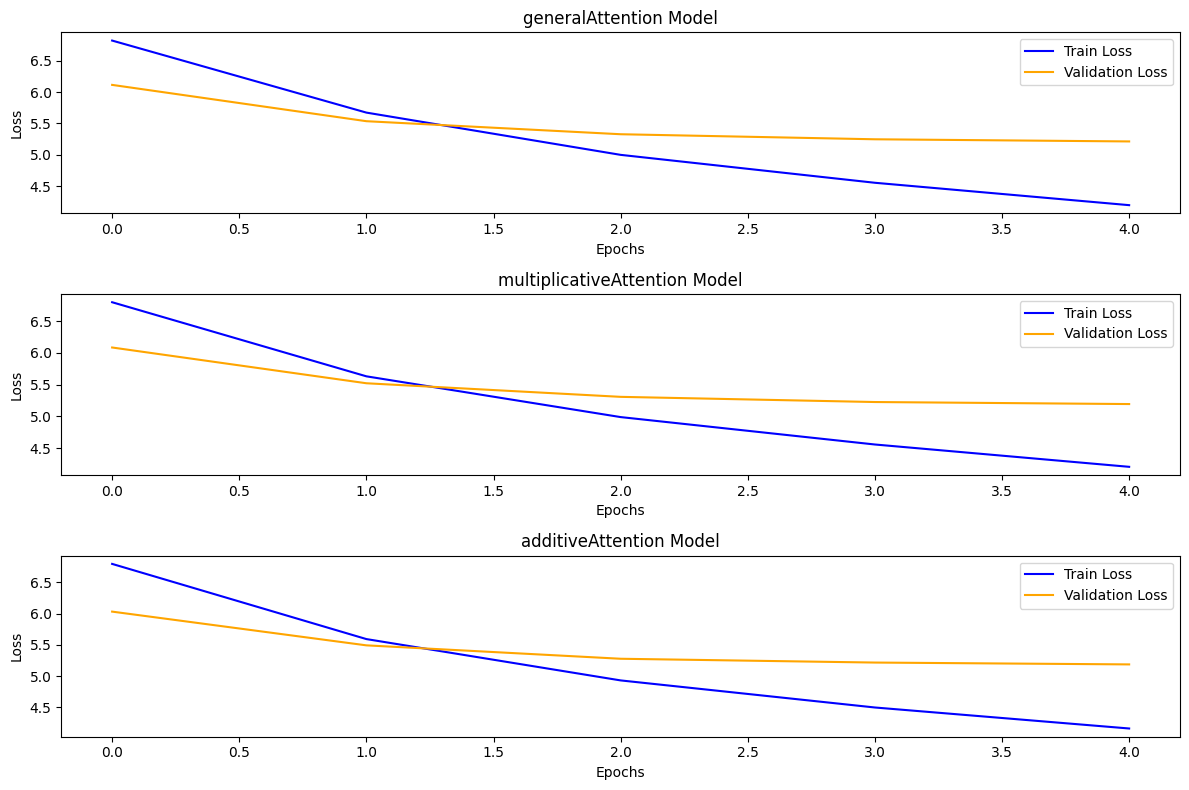

In [80]:
import matplotlib.pyplot as plt

# Create a figure to plot all models
plt.figure(figsize=(12, 8))

# Loop through the models and plot the train/validation losses
for idx, (model_name, model) in enumerate(all_models.items()):
    plt.subplot(len(all_models), 1, idx + 1)  # Create a subplot for each model
    
    # Access train and validation losses for the current model
    train_losses = model_records[model_name]['train_losses']
    valid_losses = model_records[model_name]['valid_losses']
    
    # Plot the losses
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(valid_losses, label='Validation Loss', color='orange')
    
    # Add title and labels
    plt.title(f'{model_name} Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Task 3.3
Display the attention maps generated by your model. Attention maps are crucial for understanding how the model focuses on different parts of the input sequence while generating the translation. This visualization will offer insights into the interpretability of your model. (0.5 points)

In [99]:
src_text = corpus['train'][0]['en']
print(src_text)

trg_text = corpus['train'][0]['my']
print(trg_text)

Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.
ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။


In [100]:
src = text_transform[SRC_LANGUAGE](src_text).to(device).unsqueeze(0)
trg = text_transform[TRG_LANGUAGE](trg_text).to(device).unsqueeze(0)

text_length = torch.tensor([src.size(0)]).to(dtype=torch.int64)
text_length

tensor([1])

In [101]:
with torch.no_grad():
    general_output, general_attentions = model_general_attention(src, trg)

with torch.no_grad():
    multiplicative_output, multiplicative_attentions = model_multiplicative_attention(src, trg)

with torch.no_grad():
    additive_output, additive_attentions = model_additive_attention(src, trg)

In [102]:
def get_output(output):
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1)
    trg_tokens = ['<sos>'] + [mapping[TRG_LANGUAGE][token.item()] for token in output_max]
    return trg_tokens

In [103]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src_text) + ['<eos>']

In [121]:
src_tokens

['<sos>',
 'Italy',
 'have',
 'defeated',
 'Portugal',
 '31',
 '-',
 '5',
 'in',
 'Pool',
 'C',
 'of',
 'the',
 '2007',
 'Rugby',
 'World',
 'Cup',
 'at',
 'Parc',
 'des',
 'Princes',
 ',',
 'Paris',
 ',',
 'France',
 '.',
 '<eos>']

In [132]:
import matplotlib.ticker as ticker

#Custom function to display attention
def display_attention(sentence, translation, attention, title):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention[0, 0, :, :]
    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=60)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.title(title)
    
    plt.show()
    plt.close()

In [133]:
def tokens_to_sentence(tokens, special_tokens=['<sos>', '<eos>', '<unk>']):
    # Remove special tokens
    cleaned_tokens = [token for token in tokens if token not in special_tokens]
    
    # Join the tokens into a sentence (add space between each token)
    sentence = ''.join(cleaned_tokens)
    
    return sentence

C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=60)
C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4116 (\N{MYANMAR LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4

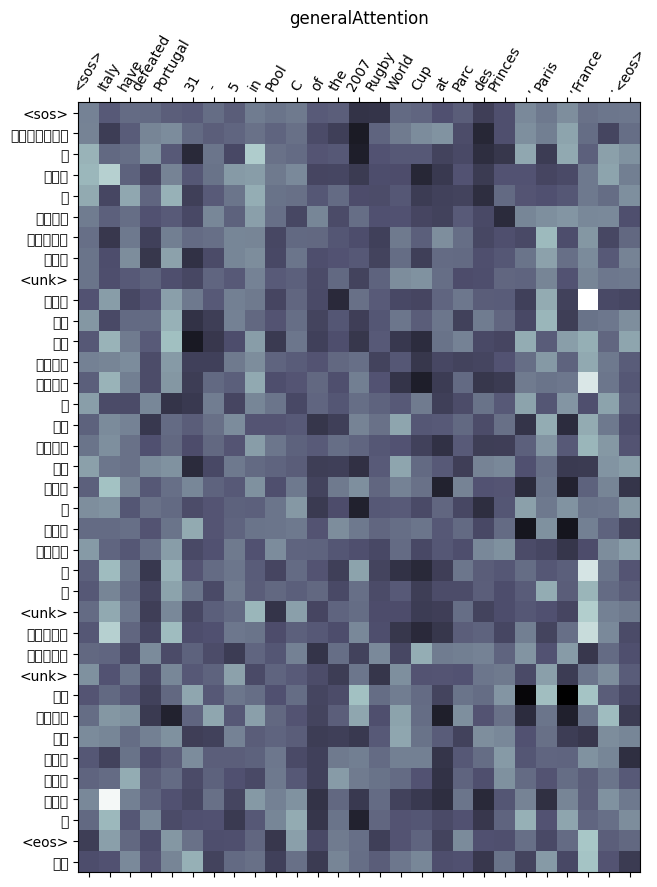

['<sos>', 'နိုင်ငံ', '၏', 'ဝင်', 'က', 'တွင်', 'မြို့', 'ကန်', '<unk>', 'မှု', 'လူ', 'ခု', 'နှစ်', 'တွင်', 'လ', 'လာ', 'တွင်', 'လူ', 'သည်', '။', 'ကို', 'လည်း', '၁', '၏', '<unk>', 'ယောက်', 'ဖြင့်', '<unk>', 'စီ', 'တွင်', 'လူ', 'ခဲ့', 'ခဲ့', 'သည်', '။', '<eos>', 'နေ']


In [134]:
# Visualize the attention map for general attention model
trg_tokens = get_output(general_output)
display_attention(src_tokens, trg_tokens, general_attentions, "generalAttention")
print(trg_tokens)

In [135]:
# Convert tokens to sentence
sentence = tokens_to_sentence(trg_tokens)

print("Converted Sentence: ")
print(sentence)

Converted Sentence: 
နိုင်ငံ၏ဝင်ကတွင်မြို့ကန်မှုလူခုနှစ်တွင်လလာတွင်လူသည်။ကိုလည်း၁၏ယောက်ဖြင့်စီတွင်လူခဲ့ခဲ့သည်။နေ


C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=60)
C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4116 (\N{MYANMAR LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4

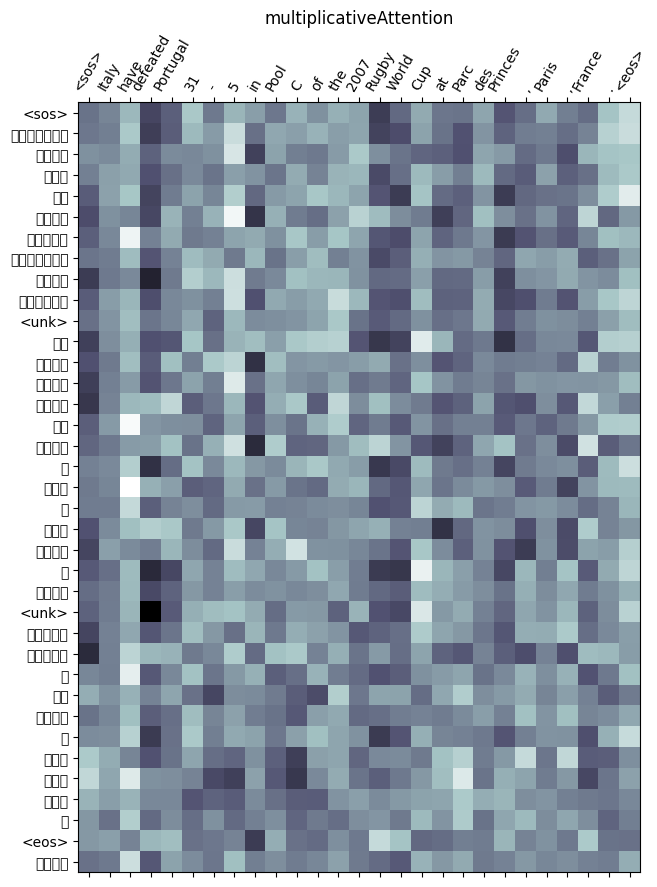

['<sos>', 'နိုင်ငံ', 'တွင်', 'ဝင်', 'ပါ', 'တွင်', 'မြို့', 'နိုင်ငံ', 'နှစ်', 'ပိုင်း', '<unk>', 'ခု', 'နှစ်', 'တွင်', 'များ', 'လာ', 'တွင်', '၊', 'သည်', '။', 'ကို', 'လည်း', '၁', 'နှစ်', '<unk>', 'ယောက်', 'ဖြင့်', '၊', 'စီ', 'တွင်', '၊', 'ခဲ့', 'ခဲ့', 'သည်', '။', '<eos>', 'တွင်']


In [136]:
# Visualize the attention map for Multiplicative attention model
trg_tokens = get_output(multiplicative_output)
display_attention(src_tokens, trg_tokens, multiplicative_attentions, "multiplicativeAttention")
print(trg_tokens)

In [137]:
# Convert tokens to sentence
sentence = tokens_to_sentence(trg_tokens)

print("Converted Sentence: ")
print(sentence)

Converted Sentence: 
နိုင်ငံတွင်ဝင်ပါတွင်မြို့နိုင်ငံနှစ်ပိုင်းခုနှစ်တွင်များလာတွင်၊သည်။ကိုလည်း၁နှစ်ယောက်ဖြင့်၊စီတွင်၊ခဲ့ခဲ့သည်။တွင်


C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=60)
C:\Users\zaqih\AppData\Local\Temp\ipykernel_66440\2750225273.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4116 (\N{MYANMAR LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\AIT (DSAI)\Spring 2025\NLP\nlp-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4

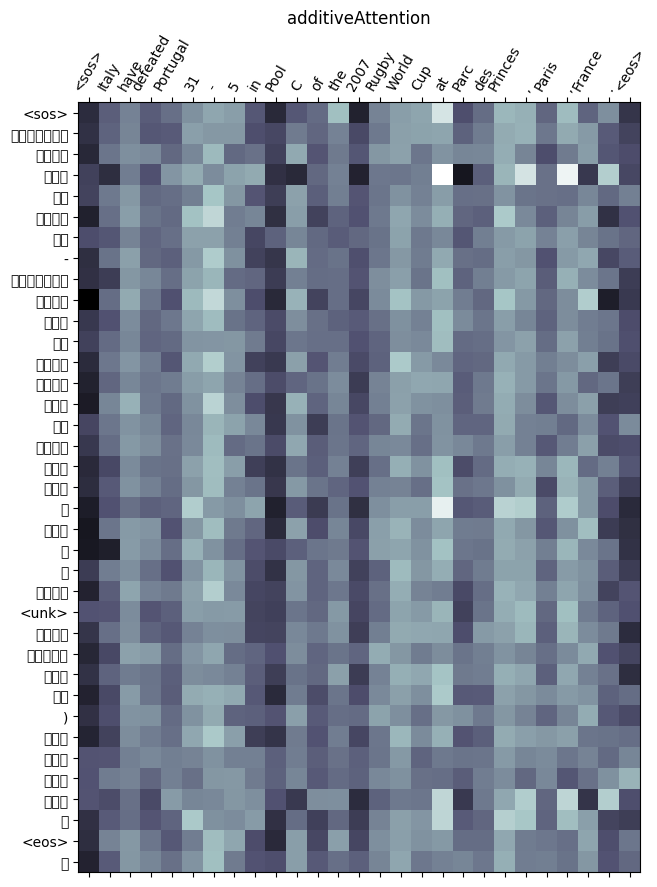

['<sos>', 'နိုင်ငံ', 'တွင်', 'ဝင်', 'ပါ', 'တွင်', 'ကဲ', '-', 'နိုင်ငံ', 'တွင်', 'ရှိ', 'ခု', 'နှစ်', 'တွင်', 'ရှိ', 'လာ', 'တွင်', 'ရှိ', 'သည်', '။', 'ကို', 'မ', '၆', 'နှစ်', '<unk>', 'နာရီ', 'ဖြင့်', 'ရှိ', 'စီ', ')', 'ရှိ', 'ခဲ့', 'ခဲ့', 'သည်', '။', '<eos>', 'ရ']


In [138]:
# Visualize the attention map for Additive attention model
trg_tokens = get_output(additive_output)
display_attention(src_tokens, trg_tokens, additive_attentions, "additiveAttention")
print(trg_tokens)

In [139]:
# Convert tokens to sentence
sentence = tokens_to_sentence(trg_tokens)

print("Converted Sentence: ")
print(sentence)

Converted Sentence: 
နိုင်ငံတွင်ဝင်ပါတွင်ကဲ-နိုင်ငံတွင်ရှိခုနှစ်တွင်ရှိလာတွင်ရှိသည်။ကိုမ၆နှစ်နာရီဖြင့်ရှိစီ)ရှိခဲ့ခဲ့သည်။ရ


## Task 3.4
Analyze the results and discuss the effectiveness of the selected attention mechanism in translating between your native language and English. (0.5 points)

- Original sentence: Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.

- MY Translation by General attention: နိုင်ငံ၏ဝင်ကတွင်မြို့ကန်မှုလူခုနှစ်တွင်လလာတွင်လူသည်။ကိုလည်း၁၏ယောက်ဖြင့်စီတွင်လူခဲ့ခဲ့သည်။နေ

- MY Translation by Multiplicative attention: 
နိုင်ငံတွင်ဝင်ပါတွင်မြို့နိုင်ငံနှစ်ပိုင်းခုနှစ်တွင်များလာတွင်၊သည်။ကိုလည်း၁နှစ်ယောက်ဖြင့်၊စီတွင်၊ခဲ့ခဲ့သည်။တွင်

- MY Translation by Addtitive attention: 
နိုင်ငံတွင်ဝင်ပါတွင်ကဲ-နိုင်ငံတွင်ရှိခုနှစ်တွင်ရှိလာတွင်ရှိသည်။ကိုမ၆နှစ်နာရီဖြင့်ရှိစီ)ရှိခဲ့ခဲ့သည်။ရ

The datset trained has been reduced to be able to train on my laptop GPU so the translation made are unsurprisingly not so accurate in real world scenario.